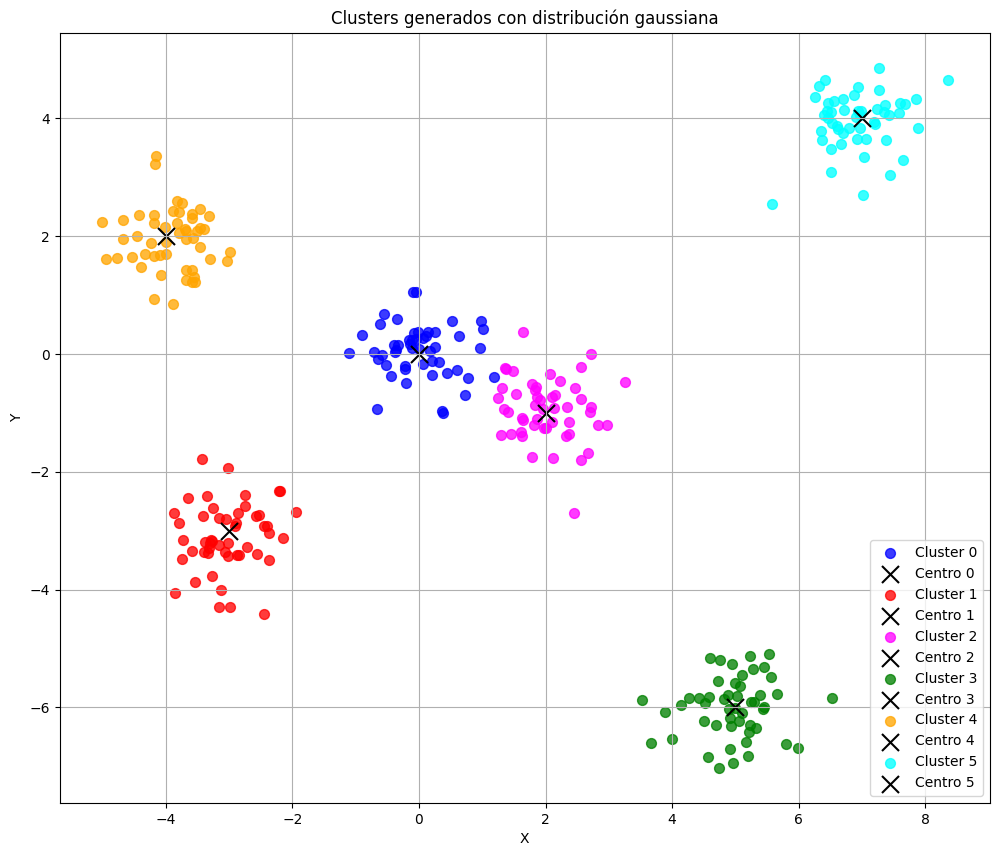

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Definimos los centros de los clusters
centros = [
    [0, 0],
    [-3, -3],
    [2, -1],
    [5, -6],
    [-4, 2],
    [7, 4]
]

def generar_datos_gaussianos(n_muestras=100, n_clusters=3, centros=None):
    """
    Genera datos sintéticos siguiendo distribuciones gaussianas.

    Parámetros:
    -----------
    n_muestras : int
        Cantidad de puntos para cada cluster.
    n_clusters : int
        Número de clusters a generar.
    centros : array 
        Coordenadas de los centros (x, y).

    Retorna:
    --------
    X : array
        Coordenadas (x, y) de todos los puntos.
    y : array
        Etiqueta del cluster al que pertenece cada punto.
    """
    X = []
    y = []
    for i in range(n_clusters):
        puntos_x = np.random.normal(centros[i][0], 0.5, n_muestras)
        puntos_y = np.random.normal(centros[i][1], 0.5, n_muestras)
        etiquetas = np.full(n_muestras, i)  # Generamos las etiquetas correctas
        puntos = np.column_stack((puntos_x, puntos_y))  # Creamos un array (N,2)
        X.append(puntos)
        y.append(etiquetas)

    X = np.vstack(X)
    y = np.hstack(y)

    indices = np.arange(len(X))
    np.random.shuffle(indices)
    return X[indices], y[indices]

def visualizame_esta(X, y, centros, n_clusters):
    """
    Visualiza los clusters generados junto con sus centros.

    Parámetros:
    -----------
    X : array
        Coordenadas (x, y) de todos los puntos.
    y : array
        Etiqueta del cluster al que pertenece cada punto.
    centros : array
        Coordenadas de los centros de los clusters.
    n_clusters : int
        Número de clusters a visualizar.
    """
    plt.figure(figsize=(12, 10))
    colores = ["blue", "red", "magenta", "green", "orange", "cyan", "purple"]
    colores = colores[:n_clusters]  # Limitamos la cantidad de colores a los clusters existentes

    for i, c in enumerate(colores):
        mask = (y == i)
        plt.scatter(X[mask, 0], X[mask, 1], color=c, s=50, alpha=0.77, label=f'Cluster {i}')
        plt.scatter(centros[i][0], centros[i][1], color="black", marker='x', s=150, label=f'Centro {i}')

    plt.legend()
    plt.title("Clusters generados con distribución gaussiana")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.show()

# Definir la cantidad de clusters basada en los centros
n_clusters = len(centros)

# Generamos los datos y los visualizamos
X, Y = generar_datos_gaussianos(50, n_clusters, centros)
visualizame_esta(X, Y, centros, n_clusters)

In [7]:
import numpy as np
class DeterministicAnnealing:
    def init(self, n_clusters=3, T_min=0.01, T_max=5.0, epsilon=1e-6, max_iter=100):
        """
        Implementación del algoritmo Deterministic Annealing para clustering.
        
        Parámetros:
        -----------
        n_clusters : int
            Número de clusters a encontrar
        T_min : float
            Temperatura mínima para detener el enfriamiento
        T_max : float
            Temperatura inicial
        epsilon : float
            Umbral de convergencia para la matriz de pertenencia
        max_iter : int
            Número máximo de iteraciones
        """
        self.n_clusters = n_clusters
        self.T_min = T_min
        self.T_max = T_max
        self.epsilon = epsilon
        self.max_iter = max_iter
        self.centroids = None
        self.M = None  # Matriz de pertenencia

    def _calcular_entropia_por_puntos(self):
        return -np.sum(self.M * np.log(self.M)) / len(self.M)

    def _calcular_entropia_por_cluster(self):
        entropia_total = 0
        lista_entropia_por_clusters = []
        for i in range(self.m_clusters):
            p_c = np.sum(self.M[:,i]) / len(self.M)
            p_x_dado_c = self.M[:,i]/np.sum(self.M[:,i])
            entropia_por_c = -np.sum(p_x_dado_c * np.log(p_x_dado_c))
            lista_entropia_por_clusters.append(entropia_por_c)
            entropia_total += p_c * entropia_por_c
        return entropia_total, np.array(lista_entropia_por_clusters)
            
    
    def _calcular_distancia(self, X, centroides):
        """
        Calcula la matriz de distancias euclidianas al cuadrado entre puntos y centroides.
        
        Utilizamos la identidad: ||a-b||² = ||a||² + ||b||² - 2<a,b>
        donde <a,b> es el producto escalar.
        """
        norma_x = np.sum(X**2, axis=1, keepdims=True)
        norma_c = np.sum(centroides**2, axis=1, keepdims=True)
        producto_escalar = np.dot(X, centroides.T)
        distancia =  norma_x + norma_c - 2*producto_escalar
        # Evitar errores numéricos
        return np.maximum(distancia, 0)
    
    def _actualizar_pertenencia(self, X, centroides, T):
        """
        Actualiza la matriz de pertenencia (probabilidades).
        
        Esta es la parte clave del algoritmo deterministic annealing:
        la probabilidad de pertenencia depende de la distancia y la temperatura.
        """

        D = self._calcular_distancia(X, centroides)
        beta = 1/T
        numerador = np.exp(-beta*D)
        denominador = np.sum(np.exp(-beta*D))
        M = numerador / (denominador + 1e-10)
        
        return M
    
    def _actualizar_centroides(self, X, M):
        """
        Actualiza las posiciones de los centroides basado en la matriz de pertenencia.
        
        Cada centroide se actualiza como un promedio ponderado de todos los puntos,
        donde los pesos son las probabilidades de pertenencia.
        """
        numerador = np.dot(M.T,X) # (n_muestrasxclster) (n_muestrasx2)
        denominador = np.sum(M, axis=0)[:,None] # (n_muestras,)
        cen = numerador / (denominador + 1e-10)
        return cen
    
    def fit(self, X):
        """
        Ajusta el modelo de Deterministic Annealing a los datos.
        
        Proceso:
        1. Inicializar centroides y temperatura
        2. Bucle principal de annealing:
           - Calcular matriz de pertenencia
           - Actualizar centroides
           - Reducir temperatura
           - Verificar convergencia
        """
        n_muestras, n_dimensiones = X.shape
      
        self.centroids = np.random.randn(self.n_clusters, n_dimensiones)
        
        # Inicializar parámetros para el bucle
        t = 0  # Contador de iteraciones
        T = self.T_max  # Temperatura inicial
        convergencia = False
        M_anterior = np.ones((n_muestras, self.n_clusters)) / self.n_clusters
        
        # Bucle principal
        while not convergencia:
            # Actualizar matriz de pertenencia con temperatura actual
            self.M =self._actualizar_pertenencia(X, self.centroids, T)
            # Actualizar centroides
            self.centroids = self._actualizar_centroides(X, self.M)
            
            # Actualizar contador y temperatura
            t += 1
            T = 1/np.log(1+t) 
            
            # Verificar convergencia
            diferencia = np.sum(np.abs(self.M - M_anterior))
            if (T<self.T_min) or (t > self.T_max) or (diferencia <= self.epsilon):
                convergencia = True
            
            # Guardar matriz actual para próxima iteración
            M_anterior = self.M.copy()
        
        return self
    
    def predict(self, X):
        """
        Predice el cluster para cada punto en X.
        
        Retorna el índice del cluster con mayor probabilidad para cada punto.
        """
        M = self._actualizar_pertenencia(X, self.centroids, self.T_min)
        return np.argmax(M, axis=1)
    
    def fit_predict(self, X):
        """
        Ajusta el modelo y predice los clusters en un solo paso.
        """
        self.fit(X)
        return self.predict(X)

In [8]:
def calcular_entropia_por_punto(self):
"""
Calcula la entropía condicional H(C|X), que es la entropía por punto.

Esta entropía mide la incertidumbre en la asignación de clusters para cada punto.
"""
    
def calcular_entropia_por_cluster(self):
    """
    Calcula la entropía condicional H(X|C), que es la entropía por cluster.
    
    Esta entropía mide qué tan uniforme es la distribución de puntos dentro de cada cluster.
    También devuelve un array con las entropías individuales de cada cluster.
    """

IndentationError: expected an indented block after function definition on line 1 (2484757674.py, line 2)

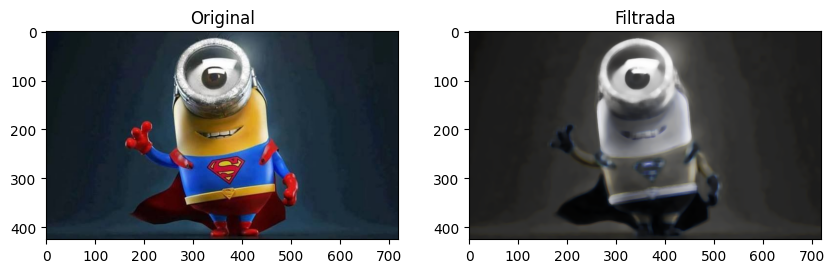

Shape de la imagen original: (425, 720, 3)
Shape de la imagen reformateada: (306000, 3)


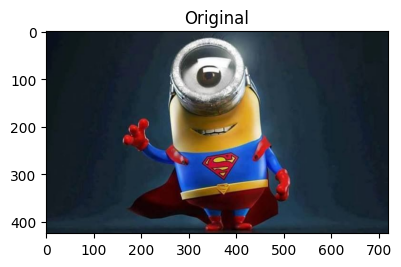

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage
# Fijamos las semillas para reproducibilidad
np.random.seed(42)
# 1. Cargar una imagen
image = np.array(Image.open('imagen.jpg'))

# 2. Preprocesamiento (opcional)
# Aplicar un filtro de mediana para reducir el ruido, cuando decimos ruido nos referimos a que haya demasiada variación en los colores de los píxeles
# en la imagen. Esto puede ayudar a mejorar la segmentación.
image_filtered = ndimage.median_filter(image, size=10) # ndimage.median_filter es una función de SciPy que aplica un filtro de mediana a la imagen. Le pasamos la imagen y el tamaño del filtro (10x10 píxeles en este caso). Esto significa que cada píxel en la imagen filtrada es reemplazado por la mediana de los píxeles en una vecindad de 10x10 píxeles alrededor de él.
# 2.1 Mostramos la imagen original y la imagen filtrada
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.imshow(image), plt.title('Original')
plt.subplot(122), plt.imshow(image_filtered), plt.title('Filtrada')
plt.show()
# 3. Reformatear la imagen para clustering
print("Shape de la imagen original:", image.shape)
pixel_values = image_filtered.reshape((-1, 3))
print("Shape de la imagen reformateada:", pixel_values.shape)
pixel_values = np.float32(pixel_values)

# 4. Aplicar Deterministic Annealing
# ...
# 5. Visualizar los resultados
plt.figure(figsize=(15, 5))
plt.subplot(131), plt.imshow(image), plt.title('Original')
# plt.subplot(132), plt.imshow(segmented_image), plt.title('Segmentada con DA')
plt.show()

In [ ]:
x